In [1]:
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import matplotlib.pyplot as plt
from math import pi

This notebook walksthough the basics of the orbithunter package, for the implementation by Matthew Gudorf for the spatiotemporal Kuramoto-Sivashinsky equation (the original purpose/foundation).

# orbithunter

The point of this package is to provide an interface and framework for solving chaotic, nonlinear partial differential equations in a spatiotemporal manner which does not have the pitfall of exponentially dynamical instabilities, because there are no dynamics. The unstable PDE, which is typically solve in terms of spatial Fourier modes as tower of ODEs, is replaced in full by a system of differential algebraic equations. This formulation allows the equations to determine the spatiotemporal
domain size (including spatial dimensions) instead of fixing them. This is believed to be a much more natural representation because of invariance to spatiotemporal translations.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding ("unstable") periodic orbits of the Kuramoto-Sivashinsky equation. 

### Introduction to the OrbitKS class and its subclasses.

Each spatiotemporal solution to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation
\begin{equation}
F(u) = u_t + u_{xx}+ u_{xxxx} + \frac{1}{2}\partial_x u^2 = 0
\end{equation}

These solutions, or initial conditions with which to find solutions, are represented via Python class objects (object oriented programming). There are a number of symmetries that the solutions are equivariant under, meaning that the application of the group operations maintain a scalar field's status as a solution. These objects represent two dimensional discretizations of $u$. orbithunter takes the opinion that to exactly define a solution the following information is required: the spatiotemporal dimensions of the spatiotemporal domain or 'tile', the discretization size, and the field values corresponding to this discretization size.

#### Creating initial conditions for periodic orbits.
Again, the user friendliness and compatibility with jupyter notebooks has been maximized. 
This makes demonstration via notebooks especially easy. 

If the user does not have access to any saved orbits, initial guesses can be created in various ways.
If the user desires more control, they can pass a custom ```state``` tensor, its current basis, and parameters i.e.

```orbit_ = OrbitKS(state=user_generated_array, basis=basis_of_user_generated_array, parameters=(T, L, 0))```

If the user does not want to create a custom state then the previous statement is adjusted accordingly; control
of the parameters is independent of the state such that

```orbit_ = OrbitKS(parameters=(T, L, 0))``` OR ```orbit_ = OrbitKS()``` are both valid.

Whatever variables are not specified are randomly generated as non-zero values (when applicable; equilibria maintain ```T=0```)
If the state is being randomly generated then the user can select a modulation strategy for the mode spectrum from the following: 

```('gaussian', 'linear', 'piecewise-exponential', 'exponential', 'random')```

The default, gaussian modulation, obeys the following formula

\begin{equation}
(gaussian)_{jk} \equiv \exp\Big(-\frac{1}{2}\frac{(k-\mu_x)^2}{\sigma_x^2}-\frac{1}{2}\frac{(j-\mu_t)^2}{\sigma_t^2}\Big) 
\end{equation}

where the default values of $\mu$ and $\sigma$ are motivated by physical scales, $\mu_x \approx \frac{L}{2\pi\sqrt(2)}, \mu_t \approx 20$

To randomly initialize a field state (via a number of different methods), call the class constructor without any input to the "state" field. Also, the string pertaining to the current basis of the "state" information is required. This method will also generate random floating point values for the dimension, which exist within a certain range (from small to medium / large-ish domains). The representation of this object in Python displays all of this information, other than the state because this is too large to print while also maintaining its utility. The default discretization is based on heuristics based on the dimensions.

In [2]:
# for reproducibility, provide a random seed to the generation process.
orbit_example = OrbitKS(seed=0)
print(repr(orbit_example))

OrbitKS({"basis": "modes", "parameters": ["107.8102", "40.349", "0"], "field_shape": ["64", "64"]})


These Orbit class instances have many many methods afforded to them, hence their utility. Let's work through some basics. To plot and display the (padded) field, simply use the plot method.

In [3]:
import orbithunter as oh
dir(oh)

['AntisymmetricOrbitKS',
 'EquilibriumOrbitKS',
 'OrbitKS',
 'RelativeEquilibriumOrbitKS',
 'RelativeOrbitKS',
 'ShiftReflectionOrbitKS',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'arrayops',
 'calculate_spatial_shift',
 'check_symbolic_log',
 'clip',
 'clipping',
 'continuation',
 'converge',
 'convergence_log',
 'convert_class',
 'core',
 'dimension_continuation',
 'discretization',
 'discretization_continuation',
 'generate_symbol_arrays',
 'glue',
 'gluing',
 'gudhi_distance',
 'gudhi_plot',
 'integration',
 'io',
 'kse_integrate',
 'mask_orbit',
 'optimize',
 'orbit_complex',
 'orbit_ks',
 'orbit_persistence',
 'parameter_based_discretization',
 'parse_class',
 'persistent_homology',
 'read_h5',
 'rediscretize',
 'rediscretize_tiling_dictionary',
 'refurbish_log',
 'so2_coefficients',
 'so2_generator',
 'swap_modes',
 'symbolic_convergence_log',
 'tile']

In [ ]:
example_orbit = OrbitKS(seed=5, parameters=(100, 100, 0.), M=96).rescale(3.5)
example_orbit.plot()

In [5]:
example_orbit

OrbitKS({"basis": "modes", "parameters": ["100.0", "100.0", "0"], "field_shape": ["64", "128"]})

In [6]:
?example_orbit.plot

There are a large number of extra parameters that can be specified; the philosophy is to utilize "keyword arguments" or kwargs
for short, to maintain readability. The docstring for all methods can be accessed by the following command in jupyter: ***NOTE THE LACK OF PARENTHESES***

There are many ways that initial conditions can be constructed, there are four templates provided for OrbitKS and its subclasses. These options are ```['random', 'gaussian', 'piecewise_exponential', 'exponential', 'linear']``` The names pertain to the type of mollifier that modulates the spatiotemporal modes. This is better demonstrated via plotting

As can be seen, It will benefit us to use an actual solution to the equations, not some arbitrary field. To find a solution starting from an initial condition, we use the "converge" function. Let's use the Gaussian spectrum scaling, rescaling the field first to a "better" magnitude. 

The converge function minimizes the cost function $\frac{1}{2}|F|^2$ where vertical bars represent the $L_2$ norm. To increase viability a number of numerical methods have been "wrapped" in order to handle orbit instances. These ***do not*** represent an exhaustive list, and a future goal is to improve the gradient descent via Nesterov acceleration (or similar methods). 

The default behavior is to use a hybrid method composed of (preconditioned) gradient descent and a direct least squares solver. The latter of these two methods is only afforded to Orbit's with small discretization sizes (hence why the random initial condition generator did not include all possible values). Like every other method, there are a large number of options. The most relevant here determine the numerical method used, the precision required to define convergence, the maximum number of iterations, etc.

In [7]:
?converge

In [8]:
example_orbit

OrbitKS({"basis": "modes", "parameters": ["100.0", "100.0", "0"], "field_shape": ["64", "128"]})

In [ ]:
converge_result = converge(example_orbit, verbose=True, preconditioning=False, method='hybrid', ftol=0)

Starting gradient descent. Initial residual=847.552508348444, target=8.192e-06, max_iter=46080
#################################################
 Residual=117.2443765 after 5000 gradient descent iterations. Current parameter values:(100.02352506050698, 100.11183729445098, 0)
#################################################
 Residual=54.1241204 after 10000 gradient descent iterations. Current parameter values:(100.03877407172463, 99.57081884688421, 0)
#################################################
 Residual=34.2294756 after 15000 gradient descent iterations. Current parameter values:(100.05276972073261, 99.24692843027923, 0)
#################################################
 Residual=26.0172278 after 20000 gradient descent iterations. Current parameter values:(100.06604008762272, 99.06650889330696, 0)
#################################################
 Residual=21.8899206 after 25000 gradient descent iterations. Current parameter values:(100.07880222215192, 98.97066297278388, 0)
####

In [ ]:
converge_result.orbit.plot()
c_orbit = converge_result.orbit

In [ ]:
converge_result = converge(example_orbit, verbose=True, preconditioning=False, method='hybrid', ftol=0)

With this converged orbit, let's see what kinds of operations are made easy by orbithunter. First differentiation. This is a class dependent method, so dx() and dt() are not required for the parent method. However, to compute the spatiotemporal mapping differentiation will always be required, so use your imagination for whatever you would call your derivative methods. 

In [59]:
single_line = converge(rediscretize(convert_class(co_, RelativeOrbitKS).rotate(1,axis=1).reflection(), new_shape=(64,64)), method='hybrid').orbit

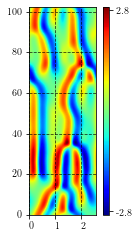

In [32]:
single_line.plot()

In [54]:
test_int = kse_integrate(single_line)

In [52]:
single_line.dx().dt().convert(to='field')

RelativeOrbitKS({"state_type": "field", "parameters": ["1.025e+02", "2.283e+01", "-6.693e-02"], "field_shape": ["64", "64"]})

The main purpose of this package is to formulate and study turbulence in a spatiotemporal manner, i.e. Physics. I currently have the relavant Physics functions in a file separate from the class files, but they are class specific and so this is arguably wrong. 

In [22]:
ks.kse_energy(orbit_, average='space')

array([0.03596948, 0.03542809, 0.03477134, 0.03402446, 0.03321617,
       0.03237751, 0.03154073, 0.03073798, 0.0300001 , 0.02935546,
       0.02882882, 0.02844043, 0.02820521, 0.0281322 , 0.02822421,
       0.0284777 , 0.02888292, 0.02942431, 0.03008107, 0.03082794,
       0.03163624, 0.03247489, 0.03331168, 0.03411443, 0.03485231,
       0.03549695, 0.03602359, 0.03641198, 0.0366472 , 0.0367202 ,
       0.0366282 , 0.03637471, 0.03596948, 0.03542809, 0.03477134,
       0.03402446, 0.03321617, 0.03237751, 0.03154073, 0.03073798,
       0.0300001 , 0.02935546, 0.02882882, 0.02844043, 0.02820521,
       0.0281322 , 0.02822421, 0.0284777 , 0.02888292, 0.02942431,
       0.03008107, 0.03082794, 0.03163624, 0.03247489, 0.03331168,
       0.03411443, 0.03485231, 0.03549695, 0.03602359, 0.03641198,
       0.0366472 , 0.0367202 , 0.0366282 , 0.03637471])